# Compression using SVD for FEM results
## Numerical Linear Algebra Project, 2019

Computing all values for circle partitioning 100.

In [8]:
import numpy as np
from vtk import vtk
from vtk.util import numpy_support as VN
import matplotlib.pyplot as plt

In [8]:
!unzip 100.zip -d ./100
!rm ./100/*.pvd
!ls -l ./100

Archive:  100.zip
  inflating: ./100/membrane_deflection_0.pvd  
  inflating: ./100/membrane_deflection_0000000.vtu  
  inflating: ./100/membrane_deflection_1.pvd  
  inflating: ./100/membrane_deflection_2.pvd  
  inflating: ./100/membrane_deflection_3.pvd  
  inflating: ./100/membrane_deflection_4.pvd  
  inflating: ./100/membrane_deflection_5.pvd  
  inflating: ./100/membrane_deflection_6.pvd  
  inflating: ./100/membrane_deflection_7.pvd  
  inflating: ./100/membrane_deflection_8.pvd  
  inflating: ./100/membrane_deflection_9.pvd  
  inflating: ./100/membrane_deflection_10.pvd  
  inflating: ./100/membrane_deflection_11.pvd  
  inflating: ./100/membrane_deflection_12.pvd  
  inflating: ./100/membrane_deflection_13.pvd  
  inflating: ./100/membrane_deflection_14.pvd  
  inflating: ./100/membrane_deflection_15.pvd  
  inflating: ./100/membrane_deflection_16.pvd  
  inflating: ./100/membrane_deflection_17.pvd  
  inflating: ./100/membrane_deflection_18.pvd  
  inflating: ./100/membrane

  inflating: ./100/membrane_deflection_63000000.vtu  
  inflating: ./100/membrane_deflection_64000000.vtu  
  inflating: ./100/membrane_deflection_65000000.vtu  
  inflating: ./100/membrane_deflection_66000000.vtu  
  inflating: ./100/membrane_deflection_67000000.vtu  
  inflating: ./100/membrane_deflection_68000000.vtu  
  inflating: ./100/membrane_deflection_69000000.vtu  
  inflating: ./100/membrane_deflection_70000000.vtu  
  inflating: ./100/membrane_deflection_71000000.vtu  
  inflating: ./100/membrane_deflection_72000000.vtu  
  inflating: ./100/membrane_deflection_73000000.vtu  
  inflating: ./100/membrane_deflection_74000000.vtu  
  inflating: ./100/membrane_deflection_75000000.vtu  
  inflating: ./100/membrane_deflection_76000000.vtu  
  inflating: ./100/membrane_deflection_77000000.vtu  
  inflating: ./100/membrane_deflection_78000000.vtu  
  inflating: ./100/membrane_deflection_79000000.vtu  
  inflating: ./100/membrane_deflection_80000000.vtu  
  inflating: ./100/membrane_

In [9]:
# reading data from raw vtk files
filenames = ['./100/membrane_deflection_' + str(i) + '000000.vtu' for i in range(100)]
array_solution = []
reader = vtk.vtkXMLUnstructuredGridReader()
for file_name in filenames:
    reader.SetFileName(file_name)
    reader.Update()  # Needed because of GetScalarRange
    data = reader.GetOutput()
    solution = VN.vtk_to_numpy(data.GetPointData().GetArray('w'))
    array_solution.append(solution)

In [10]:
array_solution = np.array(array_solution).T
print("The shape of FEM resulting array: ", array_solution.shape)

The shape of FEM resulting array:  (20076, 100)


In [11]:
n = array_solution.shape[0] # number of points in FEM
m = array_solution.shape[1]   # number of steps
S = np.random.normal(np.random.rand() + 5,100*np.random.rand(),(m,m)) #random matrix for rabdom SVD

In [12]:
#implementation of randomized SVD, references in report
def rand_svd(A, S):
    Q, R = np.linalg.qr(A @ S)
    B = Q.T @ array_solution
    # print(B.shape)# the main goal is to do svd for small matrix
    U, sigma, V = np.linalg.svd(B)
    U = Q @ U
    return U, sigma, V

In [13]:
_, s_classic, _ = np.linalg.svd(array_solution) # just to show that randomized svd is ok
U, sigma, V = rand_svd(array_solution, S)

In [14]:
print("Maximal deviation in singular values: ", str(np.max(sigma - s_classic)))

Maximal deviation in singular values:  2.220446049250313e-16


In [214]:
#finally, 2 rows to show that randomized is sufficiently faster
time_normal_svd = %timeit -q -o np.linalg.svd(array_solution)
time_rand_svd = %timeit -q -o rand_svd(array_solution)

In [296]:
print("Execution time for ordinary SVD: ", time_normal_svd)
print("Execution time for randomized SVD: ", time_rand_svd)

Execution time for ordinary SVD:  1min 14s ± 2.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Execution time for randomized SVD:  334 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
#implementation of algorithm of computing rank for low rank approximation - references in report
def opt_rank(array_solution, sigma, e):
#e = 0.001 # max set error
    x_min = np.min(array_solution)
    x_max = np.max(array_solution)
    MSE = 0
    NRMSD = 0
    rank = sigma.shape[0]
    c = m*n
    NRMSD_evolution = []
    while(NRMSD < e):
        MSE += sigma[rank - 1]/c
        NRMSD = np.sqrt(MSE)/(x_max - x_min)
        NRMSD_evolution.append(NRMSD)
        rank = rank - 1
        if(rank < 1):
            print("It makes no sense at all")
            break

    optimal_rank = rank + 1
    print(str(optimal_rank) + " is suitable rank")
    # plt.plot(NRMSD_evolution)
    return optimal_rank

3 is suitable rank
6 is suitable rank
8 is suitable rank
11 is suitable rank
14 is suitable rank


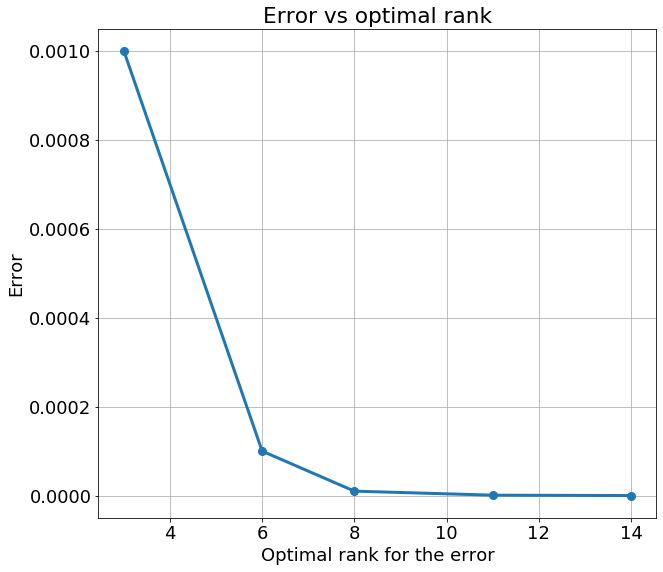

In [20]:
opt_rank_for_dif_errors = []
errors = []
e = 0.01
for i in range(1, 6):
    e=0.1*e
    opt_rank_for_dif_errors.append(opt_rank(array_solution, sigma, e))
    errors.append(e)

plt.figure(figsize=(10, 9))
plt.rcParams.update({'font.size': 18})
plt.plot(opt_rank_for_dif_errors, errors, '.-', markersize=16, linewidth=3)
plt.xlabel('Optimal rank for the error')
plt.ylabel('Error')
plt.title('Error vs optimal rank')
# plt.yscale('log')
plt.grid('on')
plt.savefig("optimal_rank_vs_error_given_error_0_01_mat_shape_20076_100_points_100.png")
plt.show()

In [10]:
#Now time to check if this compression is of any use. Lets compute compression rate
rate1 = (opt_rank_for_dif_errors[0]*(m + n + 1))/(n*m)
if(rate1 > 1):
    print("Comression rate is " + str(rate1) + " so we shouldn't perform compression")
else:
    print("Comression rate is " + str(rate1) + " so it makes sense")

Comression rate is 0.03015092647937836 so it makes sense


In [11]:
#Now time to check if this compression is of any use. Lets compute compression rate
rate = (opt_rank_for_dif_errors[2]*(m + n + 1))/(n*m)
if(rate > 1):
    print("Comression rate is " + str(rate) + " so we shouldn't perform compression")
else:
    print("Comression rate is " + str(rate) + " so it makes sense")

Comression rate is 0.08040247061167563 so it makes sense


In [22]:
#If it makes sense, lets compress it
sigma_compressed = sigma[0:opt_rank_for_dif_errors[0]]
V_compessed = V[0:opt_rank_for_dif_errors[0]]
U_compessed = ((U.T)[0:opt_rank_for_dif_errors[0]]).T

In [23]:
#Now, recompute array_solution_compessed and see visualisation for compressed data
array_solution_compressed = U_compessed @ np.diag(sigma_compressed) @ V_compessed
print("The shape of compressed array: ", array_solution_compressed.shape)

The shape of compressed array:  (20076, 100)


In [24]:
print('Minimum value of FEM resulting array: ', np.min(array_solution))
print('Maximum value of FEM resulting array: ',np.max(array_solution))

Minimum value of FEM resulting array:  0.0
Maximum value of FEM resulting array:  0.06854256772683563


In [25]:
print('Minimum value of compressed array: ',np.min(array_solution_compressed))
print('Maximum value of compressed array: ',np.max(array_solution_compressed))

Minimum value of compressed array:  -1.463912891361052e-32
Maximum value of compressed array:  0.06869525046333122


In [26]:
diff = array_solution - array_solution_compressed
for i, file_name in enumerate(filenames):
    new_file_name = './updated_100_rank_3/membrane_deflection_' + str(i) + '.vtu'
    
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(file_name)
    reader.Update()  
    data = reader.GetOutput()
    
    solution_modified = VN.numpy_to_vtk(array_solution_compressed[:, i], deep=True)
    solution_modified.SetName('updated_w')
        
    difference_mod = VN.numpy_to_vtk(diff[:, i], deep=True)
    difference_mod.SetName('diff')
    
    data.GetPointData().AddArray(solution_modified)
    data.GetPointData().AddArray(difference_mod)
    data.Modified()
    
    writer = vtk.vtkXMLUnstructuredGridWriter()
    writer.SetFileName(new_file_name)
    writer.SetInputData(data)
    writer.Update()
    writer.Write()

In [27]:
difference = array_solution - array_solution_compressed
print('Maximum difference between FEM resulting and compressed array: ', max(np.abs(np.max(difference)), np.abs(np.min(difference))))

Maximum difference between FEM resulting and compressed array:  0.00015268273649558795
